[*********************100%***********************]  1 of 1 completed


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0733 - val_loss: 0.0087
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0060
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_lo

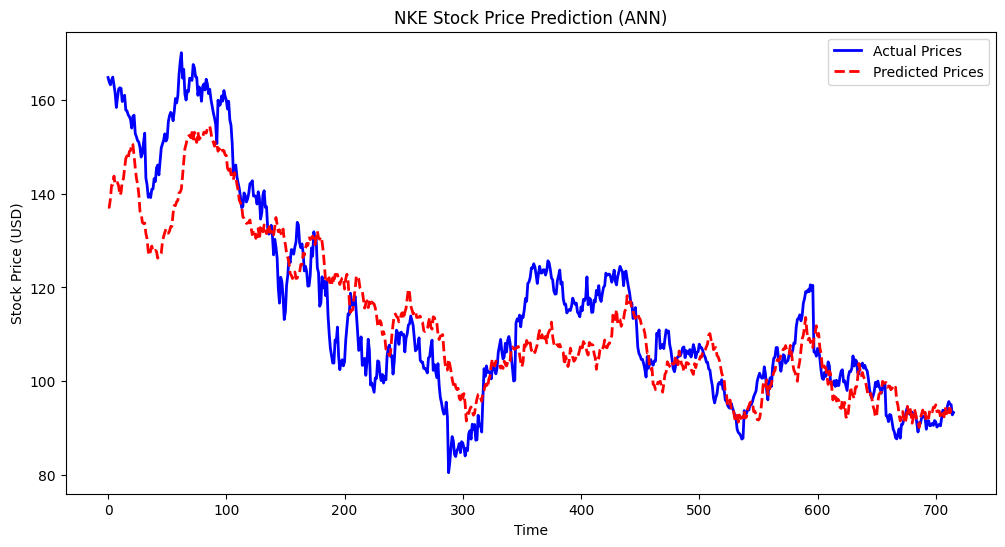

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Download stock data
def download_stock_data(ticker, start_date='2010-01-01', end_date='2024-06-14'):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Create technical indicators
def add_technical_indicators(df):
    df['20MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['50MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200MA'] = df['Close'].rolling(window=200, min_periods=1).mean()

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.loc[:, 'RSI'] = df['RSI'].fillna(50)

    df['12EMA'] = df['Close'].ewm(span=12, adjust=False, min_periods=1).mean()
    df['26EMA'] = df['Close'].ewm(span=26, adjust=False, min_periods=1).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False, min_periods=1).mean()

    df.ffill(inplace=True)
    df.bfill(inplace=True)

    return df

# Normalize the data
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close', '20MA', '50MA', '200MA', 'RSI', 'MACD']])
    return scaled_data, scaler

# Prepare the time-series data
def create_time_series_data(df, scaled_data, window_size=60):
    X = []
    y = []
    
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i])
        y.append(df['Close'].iloc[i])  

    return np.array(X), np.array(y)

# Split the data into training and testing sets
def split_data(X, y, test_size=0.2):
    train_size = int(len(X) * (1 - test_size))
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Create ANN model
def create_ann_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # Flatten the time-series input
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer (predicting one value)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Example usage
ticker = 'NKE'
df = download_stock_data(ticker)
df = add_technical_indicators(df)

scaled_data, scaler = normalize_data(df)

X, y = create_time_series_data(df, scaled_data)

X_train, X_test, y_train, y_test = split_data(X, y)

# Normalize target values
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Define input shape for ANN
input_shape = (X_train.shape[1] * X_train.shape[2],)  # Flattened input

# Create ANN model
model = create_ann_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train.reshape(X_train.shape[0], -1), y_train_scaled,  
    epochs=20, batch_size=32, 
    validation_data=(X_test.reshape(X_test.shape[0], -1), y_test_scaled), 
    callbacks=[early_stopping]
)

loss = model.evaluate(X_test.reshape(X_test.shape[0], -1), y_test_scaled)
print(f"Test loss: {loss}")

# Predictions
predictions = model.predict(X_test.reshape(X_test.shape[0], -1))

# Rescale predictions
predictions = scaler.inverse_transform(predictions)

# Rescale actual test values
y_test_original = scaler.inverse_transform(y_test_scaled)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Prices", color="blue", linewidth=2)
plt.plot(predictions, label="Predicted Prices", color="red", linestyle="dashed", linewidth=2)
plt.title(f"{ticker} Stock Price Prediction (ANN)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
